<a href="https://colab.research.google.com/github/ciepielajan/SDA_SMOG_Wawelski/blob/main/Jan/SDA_2021_04_24_Univariate%20LSTM%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zastosowanie `Univariate LSTM Models` 

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Możliwości:
1. `Multiple Parallel` - zastosowanie jednego modelu LSTM dla wszystkich sensorów korzystajac z wielu równoległych obserwacji 
* 1. `Multiple Parallel` tylko dla pm10
* 2. `Multiple Parallel + Multivariate`  pm10 + dodatkowe parametry (np: temp, ciśnienie, srednia krocząca obserwacji, zaludnienie itd)
* minus - duża ilość braków danych, każdy sensor zaczynał działanie w innym czasie. konieczność sztucznego uzupełeniania brakujacych wartości
* `do sprawdzenia` - może do modelu mozna wrzucić Nulle jako 0 (brak obserwacji) ??
2. zastosowanie jednego modelu LSTM dla każdego z sensora osobno:
* 1.  `Univariate ` - samo pm10
* 2.  `Multivariate` - pm10 + dodatkowe parametry (np: temp, ćiśnienie, srednia krocząca obserwacji, zaludnienie itd)

---

założenia:
* implementacja modelu `LSTM - Multiple Parallel`
* time series zawiera braki pomiarów dla niektórych sensorów. 
* * aby przetestować działanie LSTM używamy "ułatwienia" uzupełniajac brakujące obserwacje metodą `.interpolate()`, z parametrami `method='linear', axis=1`
* * *  aby wyniki były najbardziej zbliżone do prawdziwych można zastosować model K-najbliższych dla lokazliacji sensorów. 
* *  * drugą możliwością jest rezygnacja z interpolacji brakujacych obserwacji i obliczanie modelu LSTM dla każdego sensora osobno na okresie czasowym z którego sa wszystkie obserwacje. 

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [32]:
# !gdown --id "186S03hFJ67K4eV1BWb2_6lZxAYG7dBM4"
# !unzip -q "archive.zip" -d data/
all_file_names = glob.glob("data/*2017.csv")
all_file_names = sorted(all_file_names)

jan = pd.read_csv(all_file_names[4])
feb = pd.read_csv(all_file_names[3])
mar = pd.read_csv(all_file_names[7])
apr = pd.read_csv(all_file_names[0])
may = pd.read_csv(all_file_names[8])
jun = pd.read_csv(all_file_names[6])
jul = pd.read_csv(all_file_names[5])
aug = pd.read_csv(all_file_names[1])
sep = pd.read_csv(all_file_names[11])
octo = pd.read_csv(all_file_names[10])
nov = pd.read_csv(all_file_names[9])
dec = pd.read_csv(all_file_names[2])

year = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec])
year["UTC time"] = pd.to_datetime(year["UTC time"], format="%Y-%m-%dT%H:%M:%S")
year = year.set_index("UTC time")
year.shape

(8593, 336)

In [33]:
year.head(2)

,3_temperature,3_humidity,3_pressure,3_pm1,3_pm25,3_pm10,140_temperature,140_humidity,140_pressure,140_pm1,140_pm25,140_pm10,142_temperature,142_humidity,142_pressure,142_pm1,142_pm25,142_pm10,147_temperature,147_humidity,147_pressure,147_pm1,147_pm25,147_pm10,169_temperature,169_humidity,169_pressure,169_pm1,169_pm25,169_pm10,170_temperature,170_humidity,170_pressure,170_pm1,170_pm25,170_pm10,171_temperature,171_humidity,171_pressure,171_pm1,...,228_pressure,228_pm1,228_pm25,228_pm10,263_temperature,263_humidity,263_pressure,263_pm1,263_pm25,263_pm10,622_temperature,622_humidity,622_pressure,622_pm1,622_pm25,622_pm10,713_temperature,713_humidity,713_pressure,713_pm1,713_pm25,713_pm10,808_temperature,808_humidity,808_pressure,808_pm1,808_pm25,808_pm10,857_temperature,857_humidity,857_pressure,857_pm1,857_pm25,857_pm10,895_temperature,895_humidity,895_pressure,895_pm1,895_pm25,895_pm10
UTC time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,68.0,102279.0,115.0,127.0,196.0,-3.0,57.0,102505.0,196.0,222.0,346.0,0.0,49.0,102689.0,124.0,145.0,229.0,2.0,25.0,102379.0,148.0,176.0,277.0,1.0,27.0,102437.0,147.0,...,102253.0,184.0,218.0,322.0,0.0,54.0,101672.0,137.0,153.0,235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,68.0,102228.0,105.0,116.0,180.0,-3.0,56.0,102454.0,187.0,211.0,330.0,0.0,49.0,102635.0,124.0,145.0,230.0,1.0,25.0,102325.0,131.0,156.0,247.0,0.0,27.0,102387.0,129.0,...,102201.0,146.0,169.0,250.0,0.0,52.0,101623.0,119.0,132.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pobranie nazw wszytkich kolumn reprezentujących pm10

In [34]:
columns_pm10 = [ i  for i in year.columns if  i.split("_")[1] == "pm10"]
year_pm10 = year[columns_pm10]
year_pm10[:3]

,3_pm10,140_pm10,142_pm10,147_pm10,169_pm10,170_pm10,171_pm10,172_pm10,173_pm10,174_pm10,176_pm10,177_pm10,178_pm10,179_pm10,180_pm10,181_pm10,182_pm10,183_pm10,184_pm10,185_pm10,187_pm10,189_pm10,192_pm10,194_pm10,195_pm10,196_pm10,201_pm10,202_pm10,203_pm10,204_pm10,205_pm10,208_pm10,209_pm10,210_pm10,211_pm10,212_pm10,213_pm10,214_pm10,215_pm10,216_pm10,218_pm10,219_pm10,220_pm10,221_pm10,222_pm10,223_pm10,225_pm10,226_pm10,227_pm10,228_pm10,263_pm10,622_pm10,713_pm10,808_pm10,857_pm10,895_pm10
UTC time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,NaN,NaN,196.0,346.0,229.0,277.0,256.0,219.0,205.0,212.0,254.0,183.0,335.0,169.0,215.0,NaN,227.0,146.0,NaN,NaN,155.0,213.0,223.0,90.0,224.0,213.0,239.0,378.0,201.0,220.0,NaN,168.0,165.0,209.0,275.0,196.0,230.0,195.0,156.0,NaN,280.0,123.0,210.0,208.0,319.0,334.0,477.0,346.0,171.0,322.0,235.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,NaN,NaN,180.0,330.0,230.0,247.0,228.0,226.0,227.0,238.0,224.0,197.0,339.0,166.0,216.0,NaN,192.0,143.0,NaN,NaN,144.0,221.0,259.0,74.0,231.0,215.0,241.0,350.0,203.0,228.0,NaN,189.0,164.0,230.0,250.0,227.0,222.0,216.0,161.0,NaN,328.0,122.0,216.0,206.0,362.0,287.0,482.0,308.0,177.0,250.0,203.0,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,NaN,NaN,189.0,333.0,201.0,203.0,240.0,224.0,213.0,264.0,210.0,175.0,348.0,188.0,197.0,NaN,169.0,132.0,NaN,NaN,142.0,246.0,282.0,71.0,239.0,232.0,254.0,337.0,199.0,252.0,NaN,168.0,153.0,243.0,262.0,224.0,237.0,235.0,181.0,NaN,292.0,132.0,233.0,226.0,371.0,256.0,474.0,277.0,193.0,237.0,162.0,NaN,NaN,NaN,NaN,NaN


wybranie sesnora z najmniejszą ilością nulli

In [51]:
year_pm10.isnull().sum().sort_values(ascending=True).index[0]

'212_pm10'

In [52]:
year_pm10_212 = year_pm10["212_pm10"]

In [57]:
"ilość brakujących obserwacji", year_pm10_212.isnull().sum()

('ilość brakujących obserwacji', 8)

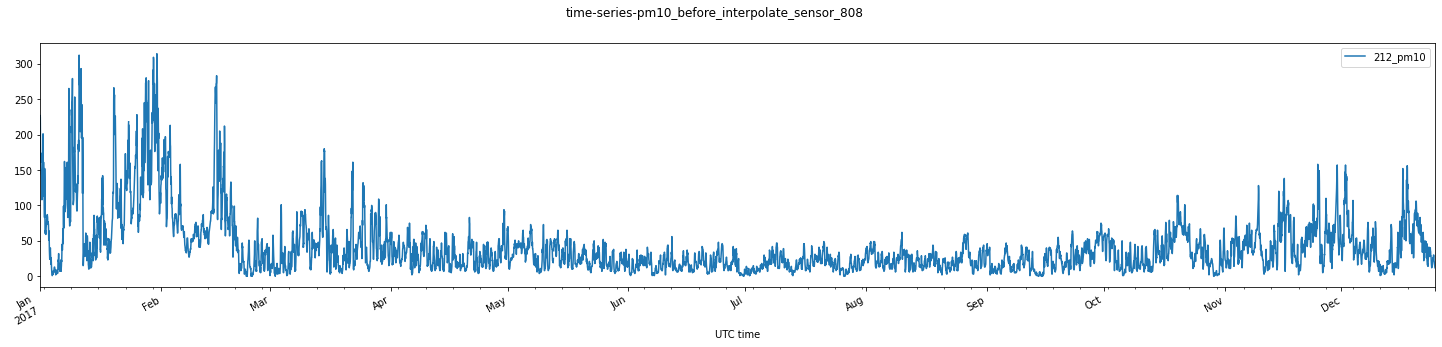

In [55]:
year_pm10_212.plot(figsize=(25,5), legend=True, subplots=True, title="time-series-pm10_before_interpolate_sensor_808")
# plt.savefig('time-series-pm10_before_interpolate_sensor_808.png')
plt.show()
plt.close()

interpolacja 

In [58]:
year_pm10_212.interpolate(method='linear', axis=0, inplace=True)
"ilość nulli po interpolacji",year_pm10_212.isnull().sum().sum()

('ilość nulli po interpolacji', 0)

Sprawdzmy czy oś czasu jest kompletna

In [59]:
"Długość indexu ze zbioru", len(year_pm10_212.index)

('Długość indexu ze zbioru', 8593)

In [60]:
"pożądana długość indexu ", len(pd.date_range(start=year_pm10_212.index.min(), end=year_pm10_212.index.max(), freq='1H'))

('pożądana długość indexu ', 8593)

Zastosowanie `Univariate LSTM Models`  wg:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/